# Анализ оттока клиентов банка

За последнее время в банке повысился отток клиентов. Ранее было проведено исследование оттока, составлены дэшборды и выделены сегменты, но клиентская база поменялась и текущие решения не работают. Заказчик анализа - отдел маркетинга банка, для которого необходимо выделить сегменты клиентов банка с наибольшим показателем оттока. В дальнейшем отдел маркетинга планирует проводить рассылки клиентам банка из выделенных сегментов. Поскольку проведение рассылок не автоматизировано и производится вручную, выделенные сегменты должны обеспечивать максимально таргетированный подход и не быть слишком объемными.

**Цель исследования:** определить причины оттока клиентов банка и сформулировать рекомендации для отдела маркетинга по их удержанию.

**Задачи исследования:** 

- определить пригодность исходных данных для дальнейшего анализа, провести предобработку данных;
- проанализировать наличие интервалов значений/характеристик, которые характеризуют ушедших клентов;
- провести корреляционный анализа данных;
- составить потрет клиентов, склонных и не склонных уходить из банка;
- сформулировать и проверить гипотезы о наличии статистически значимой разницы между отдельными характеристиками ушедших и оставшихся клиентов;
- на основании проведенного исследовательского анализа данных выделить сегменты клиентов с уровнем оттока выше, чем в среднем по банку;
- сформулировать рекомендации для отдела маркетинга по удержанию клиентов из выделенных сегментов. 

## Краткие выводы по результатам анализа

По результатам анализа распределения непрерывных и категориальных признаков были выявлены следующие отточные интервалы и критерии (ранжированные в порядке убывания значимости по результатам корреляционного анализа по методу `phik`):

- количество единиц собственности: 3 и более;
- активность клиента: активный за оцениваемый интервал времени;
- количество продуктов банка, используемых клиентом: 3 и более;
- количество баллов кредитного скоринга: от 820 до 920 (с пиком в районе 850-900 баллов);
- пол: мужчина;
- кредитная карта банка: отсутствует;
- возраст: от 25 до 35 лет, от 50 до 60 лет;
- оценочный размер заработной платы: от 85 до 230 тысяч;
- город проживания: Ярославль;
- баланс средств: свыше 750 тысяч.

Проверка статистических гипотез показала, что даже такие относительно небольшие различия, как 1,5 года в возрасте либо порядка 7000 в заработной плате являются статистически значимыми и могут быть учтены при сегментации клиентов. 
По результатам сегментации было выявлено три группы пользователей, с которым предлагается работать маркетинговому отделу для снижения уровня оттока клиентов:

Сегмент 1 – баланс свыше 750 тыс., без кредитной карты, активные – рекомендация: предложить специализированную кредитную карту для путешествий.

Сегмент 2 – клиенты-мужчины, возраст 50-60 лет, более 1 банковского продукта – рекомендация: предложить специальные условия (кэшбэк, скидки) на товары для строительства и садово-дачных работ и отдыха.

Сегмент 3 – кредитный скорринг 850-900 баллов, проживающие в г. Ярославль, более 3 единиц собственности – рекомендации: предложить скидку на страховой продукт при страховании более 1 единицы собственности. 

## Обзор данных

Устанавливаем библиотеку `phik`.

In [1]:
!pip install phik 


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Импортируем необходимые для анализа данных библиотеки.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import numpy as np
from phik import resources, report
from phik.report import plot_correlation_matrix
from scipy import stats as st
import json
from IPython.display import display, HTML

Прочитаем файл `bank_scrooge.csv` с данными (путь к данным храниться в файле формата json) и сохраним его в переменной `data`:

In [3]:
# Reading of JSON file
with open('config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)
 
# Reading the CSV file using the path from the JSON file
dataset_path_bank_analysis = config['dataset_path_bank_analysis']
data = pd.read_csv(dataset_path_bank_analysis)

Уберем ограничения при отображении количества столбцов, строк, ширины столбцов.

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Выведим первые строки наборов данных и общую информацию о датафрейме.

In [5]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


В исходном датафрейме 10 000 строк с информацией о клиентах банка. При этом не для всех клиентов указаны данные о возрасте (`age`) и балансе средств на счетах (`balance`).

## Предобработка данных

Поскольку в дальнейшем планируется использование датафрейма для глубокого анализа данных, проведем их предобработку.

### Проверка корректности наименования колонок

Для дальнейшей работы приведем наименования столбцов в датафрейме к нижнему регистру, а также добавим нижнее подчеркивание между словами в названиях столбцов:

In [7]:
data.columns = ['user_id', 
                'score', 
                'city', 
                'gender', 
                'age', 
                'equity', 
                'balance', 
                'products', 
                'credit_card', 
                'last_activity', 
                'est_salary', 
                'churn']

In [8]:
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


### Проверка наличия дубликатов и их обработка

Проверим наличие явных дубликатов:

In [9]:
data.duplicated().sum()

0

Явные дубликаты в датафреме отсутствуют. Для проверки неявных дубликатов для начала напишем функцию, которая выведет уникальные значения для переданных ей столбцов. В качестве столбцов передадим те, в которых значения представляют из себя категории и могут содержать опечатки:

In [10]:
def print_unique_values(df, columns):
    for column in columns:
        if column in df.columns:
            unique_values = df[column].unique()
            print(f"Уникальные значения для столбца '{column}':")
            print(unique_values)
            print()  
        else:
            print(f"Столбец '{column}' не найден в DataFrame.\n")


columns = ['city', 'gender', 'equity', 'products', 'credit_card', 'last_activity', 'churn'] 
print_unique_values(data, columns)

Уникальные значения для столбца 'city':
['Рыбинск' 'Ярославль' 'Ростов']

Уникальные значения для столбца 'gender':
['Ж' 'М']

Уникальные значения для столбца 'equity':
[1 5 0 4 3 2 6 7 8 9]

Уникальные значения для столбца 'products':
[2 3 1 4 5 0]

Уникальные значения для столбца 'credit_card':
[0 1]

Уникальные значения для столбца 'last_activity':
[1 0]

Уникальные значения для столбца 'churn':
[1 0]



Опечатки в данных в указанных выше столбцах отсутствуют, однако стоит обратить внимание на то, что у кого-то из клиентов в качестве информации об используемых банковских продуктах значится 0. Выведем таких клиентов:

In [11]:
data.loc[data['products'] == 0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


В датафрейме есть информация только об одном клиенте, не использующем ни один продукт. Поскольку данный клиент также не пользуется кредитной картой, у него нет активности за последнее время, и он значится как ушедший, можно рассмотреть данную строку как выброс в датафреме и удалить ее. 

In [12]:
data = data.loc[data['products'] != 0]

Теперь проверим, есть ли дубликаты среди идентификационных номеров пользователей. 

In [13]:
data.duplicated(subset = ['user_id']).sum()

73

Было выявлено 73 дубликата в столбце `user_id`. Выведем их для поиска закономерностей:

In [14]:
# Передадим дубликаты по столбцу user_id переменной
duplicates_mask = data.duplicated(subset=['user_id'], keep=False)

# Отфильтруем дубликаты и выведим как датафрейм
duplicates_df = data[duplicates_mask]
duplicates_df = duplicates_df.sort_values(by=['user_id', 'city'])
duplicates_df.head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1


По результатам анализа данных выше можно сделать вывод о том, что клиенты с одинаковыми `user_id` - это разные люди, поскольку у них различаются данные по кредитной оценке, полу, возрасту и прочие показатели. При этом задвоение данных в столбце `user_id` происходит у двух филиалов банка - в городах Ярославль и Рыбинск. Стоит довести данную информацию до сведения заказчика, чтобы в дальнейшем можно было избежать задвоения данных и связанных с ним проблем у операторов/клиентов банка. 

### Кодирование данных

Для того, чтобы в дальнейшем смотреть корреляцию числовых показателей с категориальными неупорядоченными применим `pandas.get_dummies()`:

In [15]:
# Создадим копии исходных столбцов
data['gender_code'] = data['gender']
data['city_code'] = data['city']

# Произведем кодирование выбранных столбцов
data = pd.get_dummies(data, columns = ['gender_code', 'city_code'])

# Изменим названия новых столбцов
data.rename(columns={'gender_code_Ж': 'gender_Ж', 
                   'gender_code_М': 'gender_М', 
                   'city_code_Ростов': 'Ростов',
                   'city_code_Рыбинск': 'Рыбинск',
                   'city_code_Ярославль': 'Ярославль'}, inplace=True)

# Выведим первые пять строк датафрейма для проверки 
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М,Ростов,Рыбинск,Ярославль
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,True,False,False,True,False
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,True,False,False,True,False
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,True,False,False,True,False
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,True,False,False,False,True
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,False,True,False,False,True


### Исследование пропущенных значений, обработка пропусков

При обзоре общей информации о датафреме выяснилось наличие пропусков в столбцах `age` и `balance`. Количество пропусков в столбце `age` составляет менее 1% (26/9999) данных. Выведем эти пропуски в виде таблицы:

In [16]:
age_missed = data.loc[data['age'].isna()]

age_missed_st = f'''
<div style="max-height:200px; overflow:auto;">
    {age_missed.to_html(index=False)}
</div>
'''

display(HTML(age_missed_st))

user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М,Ростов,Рыбинск,Ярославль
228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0,False,True,False,False,True
187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0,True,False,False,True,False
221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0,False,True,False,False,True
138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1,True,False,True,False,False
210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0,False,True,False,True,False
218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0,True,False,False,True,False
151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0,True,False,False,True,False
210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0,True,False,False,True,False
219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0,True,False,False,True,False
184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0,True,False,False,False,True


В выведенных строках не выявлено какой-либо очевидной закономерности между пропусками в столбце `age` и другими данными в датафрейме. Посмотрим при помощи метода `corr()`, есть ли корреляция между пропусками в столбце `age` и прочими характеристиками клиентов:

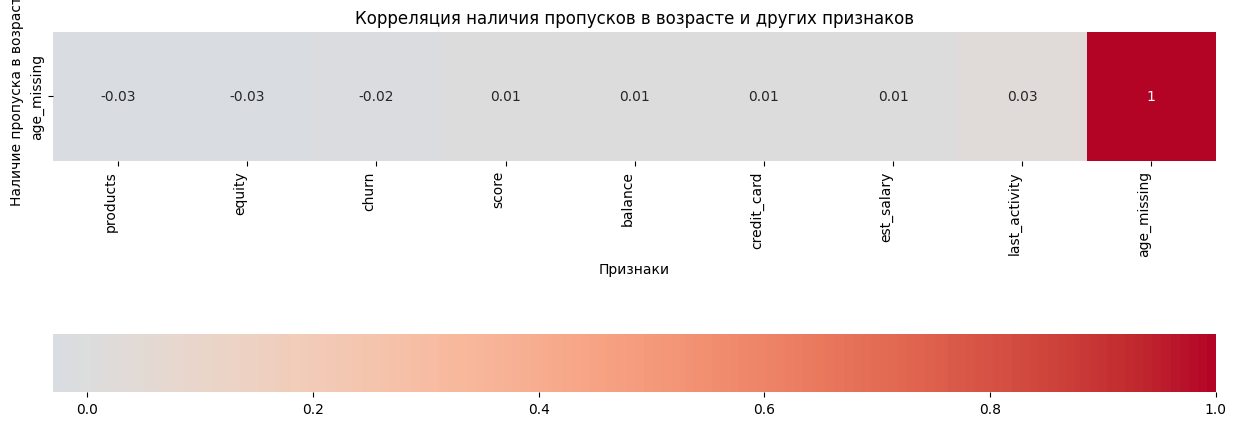

In [17]:
# Создаем столбец с булевыми значениями, указывающий на наличие или отсутствие пропусков в столбце 'age'
data['age_missing'] = data['age'].isnull().astype(int)

# Убираем столбец 'user_id', так как он не несет полезной информации для корреляции, а также столбец 'age'
data_for_corr_a = data.drop(columns=['user_id', 'age'])

# Выбираем только числовые столбцы
data_for_corr_a_numeric = data_for_corr_a.select_dtypes(include=[float, int])

# Вычисляем матрицу корреляции
correlation_matrix = data_for_corr_a_numeric.corr()

# Извлекаем строку 'age_missing' и сортируем по значениям корреляции, транспонируем таблицу для удобства отображения
age_missing_row = correlation_matrix.loc['age_missing'].sort_values(ascending=True).to_frame().T

# Округляем значения чисел до двух знаков после разделителя
age_missing_row = age_missing_row.round(2)

# Создаем heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(age_missing_row, 
            square=True, 
            annot=True, 
            cmap='coolwarm', 
            cbar_kws={'orientation': 'horizontal'}, 
            center=0)

# Настройка графика
plt.title('Корреляция наличия пропусков в возрасте и других признаков')
plt.xlabel('Признаки')
plt.ylabel('Наличие пропуска в возрасте')
plt.xticks(rotation=90, ha='right')
plt.show()

В соответствии со шкалой Чеддока у пропусков возрастной характеристики клиентов нет даже слабой связи с остальными клиентскими характеристиками. Таким образом, путем корреляционного анализа также не выявлена зависимость возраста клиентов от прочих их характеристик. 

Вывидем гистограмму распределения клиентов по возрастам:

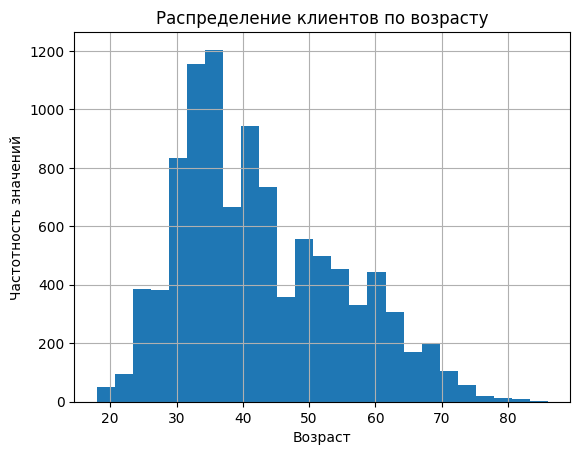

In [18]:
data['age'].hist(bins = 25)
plt.title('Распределение клиентов по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Частотность значений');

Можно сделать вывод о том, что данные пропуски относятся к категории `MCAR (Missing Completely at Random)`, то есть они отсутствуют совершенно случайно. Поскольку остальные данные в строках присутствуют, для их сохранения в датафрейме заполним пропуски медианными значениями (чтобы снизить влияние выбросов, так как в данных, например, есть крайне небольшое количество клиентов старше 75 лет, чьи показатели могут значительно повлиять на увеличение среднего возраста).

In [19]:
data['age'] = data['age'].fillna(data['age'].median())

Теперь посмотрим на пропуски в столбце `balance`. Их значительно больше - порядка 23% (2249/9999).

In [20]:
balance_missed = data.loc[data['balance'].isna()]

balance_missed_st = f'''
<div style="max-height:200px; overflow:auto;">
    {balance_missed.to_html(index=False)}
</div>
'''

display(HTML(balance_missed_st))

user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М,Ростов,Рыбинск,Ярославль,age_missing
120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,True,False,False,True,False,0
133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0,True,False,False,False,True,0
148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0,False,True,True,False,False,0
172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0,False,True,True,False,False,0
127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0,True,False,False,True,False,0
177415,896.0,Рыбинск,Ж,47.0,0,NaN,1,0,0,225060.35,0,True,False,False,True,False,0
155730,946.0,Ярославль,Ж,47.0,0,NaN,2,1,1,660015.85,0,True,False,False,False,True,0
205226,944.0,Ярославль,М,35.0,0,NaN,2,1,1,239843.39,0,False,True,False,False,True,0
173175,924.0,Рыбинск,Ж,51.0,0,NaN,1,1,1,248844.47,0,True,False,False,True,False,0
228585,956.0,Ростов,М,41.0,0,NaN,1,1,0,115117.10,0,False,True,True,False,False,0


Также проверим, есть ли в основном датафрейме клиенты с нулевым балансом:

In [21]:
data.loc[data['balance'] == 0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М,Ростов,Рыбинск,Ярославль,age_missing
3900,179831,730.0,Ярославль,М,18.0,0,0.0,2,1,1,64548.33,0,False,True,False,False,True,0
6757,148456,813.0,Ярославль,М,20.0,2,0.0,2,1,0,23876.51,0,False,True,False,False,True,0


Для параметра "баланс" также выведем матрицу корреляции пропусков с прочими характеристиками клиентов для поиска взаимосвязей:

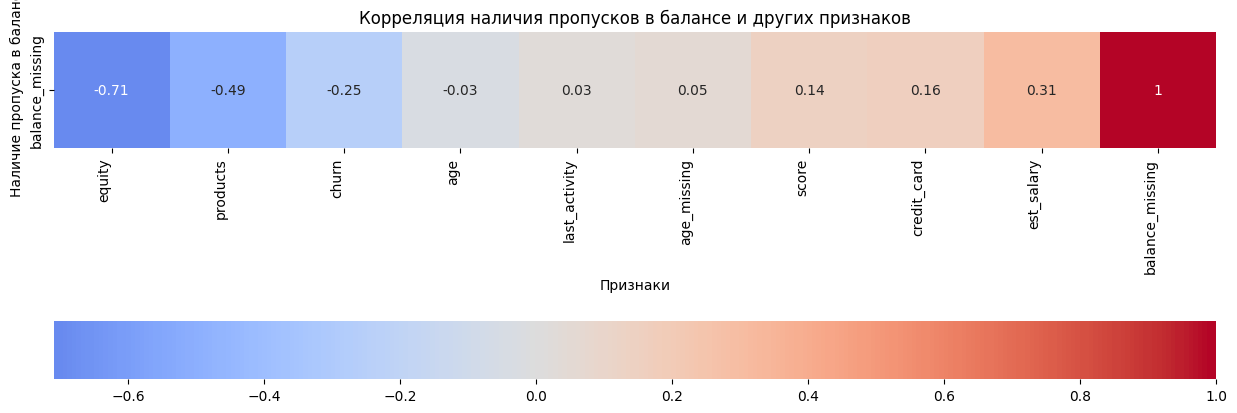

In [22]:
# Создаем столбец с булевыми значениями, указывающий на наличие или отсутствие пропусков в столбце 'balance'
data['balance_missing'] = data['balance'].isnull().astype(int)

# Убираем столбец 'user_id', так как он не несет полезной информации для корреляции, а также столбец 'balance'
data_for_corr_b = data.drop(columns=['user_id', 'balance'])

# Выбираем только числовые столбцы
data_for_corr_b_numeric = data_for_corr_b.select_dtypes(include=[float, int])

# Вычисляем матрицу корреляции
correlation_matrix_b = data_for_corr_b_numeric.corr()

# Извлекаем строку 'balance_missing' и сортируем по значениям корреляции, 
# транспонируем таблицу для удобства отображения
balance_missing_row = correlation_matrix_b.loc['balance_missing'].sort_values(ascending=True).to_frame().T

# Округляем значения чисел до двух знаков после разделителя
balance_missing_row = balance_missing_row.round(2)

# Создаем heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(balance_missing_row, 
            square=True, 
            annot=True, 
            cmap='coolwarm', 
            cbar_kws={'orientation': 'horizontal'}, 
            center=0)

# Настройка графика
plt.title('Корреляция наличия пропусков в балансе и других признаков')
plt.xlabel('Признаки')
plt.ylabel('Наличие пропуска в балансе')
plt.xticks(rotation=90, ha='right')
plt.show()

Среди клиентов, для которых на указан баланс средств по банковским продуктам есть все категории клиентов, как мужчины, так и женщины, клиенты с высоким и низким рейтингом, разного возраста, из всех трех городов, пользующиеся разным количеством продуктов, активные и неактивные, ушедшие и не ушедшие. Единственное, что их объединяет - ни у кого из них нет более 1 единицы собственности, а у большинства собственность указана как нулевая. При этом большинство клиентов без данных о балансе остаются клиентами банка. 

В соответствии с результатами корреляционного анализа самая сильная (при этом негативная) корреляция у признака `balance` с признаком `equity` - 0,71 - по шкале Чеддока характеристика такой связи относится к высокой (диапазон от 0,7 до 0,9). 

В целом пропуски в столбце `balance` можно охарактеризовать как `MNAR (Missing Not at Random)`, пропуски зависят от данных, однако без дополнительного обоснования восстановить их по имеющимся данным из текущего датафрейма не представляется возможным. Также мы не можем утверждать, что у всех клиентов без указания баланса он нулевой (нулевой баланс клиентов указывается в датафрейме эксплицитно). Поскольку объем данных с пропущенным значением `balance` является значительным (23%), оставим пропуски в датафрейме. 

### Исследование соответствия типов данных

Значения в столбцах `score` и `age` представляют собой целые числа, в то время как имеют тип данных `float`. Приведем тип данных в данных столбцах в соответствие с их содержимым:

In [23]:
data['score'] = data['score'].astype(int)
data['age'] = data['age'].astype(int)

По результатам предобработки данных можно сделать вывод о том, что представленный датафрейм отличается относительной полнотой данных, в датафрейме отсутствуют явные дубликаты. Стоит отметить, что у двух филиалов банка (Ярославль и Рыбинск) происходит задвоение идентификационных номеров клиентов, что в дальнейшем может затруднять работу операторов и приводить к ошибкам. В рамках предобработки данных были приведены к нижнему регистру и единообразию написания названия столбцов, изменен тип данных на `int` в столбцах, содержащих целые значения. По результатам корреляционного анализа пропуски с столбце `age` (менее 1% данных) были заменены медианным значением, пропуски в столбце `balance` (23%) оставлены без изменений, но добавлен столбец с булевыми значениями, характеризующий наличие/отсутствие данных о балансе у клиентов. Также данные столбцов, содержащих категориальные  неупорядоченные данные, были закодированы булевыми значениями для дальнейшего использования при корреляционном анализе. 

## Исследовательский анализ данных

В первую очередь отразим, сколько клиентов ушли и остались в целом по банку в процентном и абсолютном выражениях:

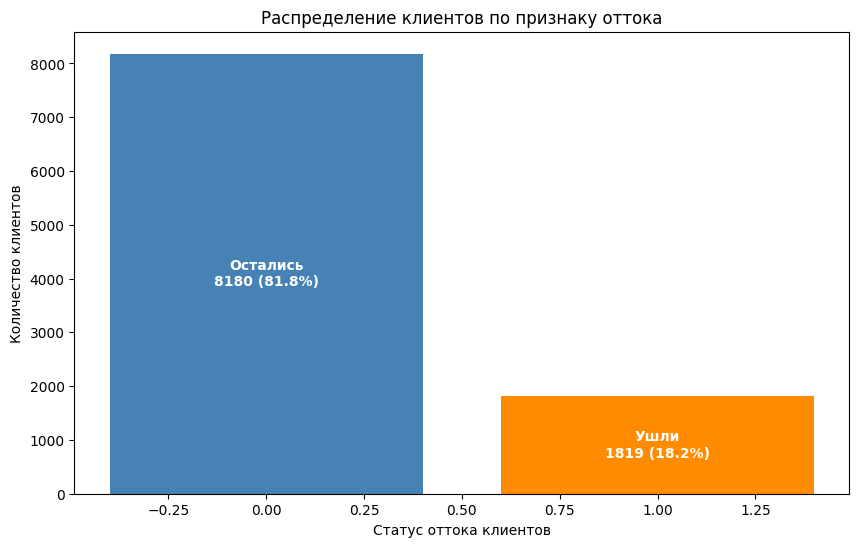

In [24]:
# Считаем количество каждой категории в столбце 'churn'
churn_counts = data['churn'].value_counts()

# Определяем метки и значения
labels = churn_counts.index
sizes = churn_counts.values

# Определяем процентные значения для меток
percentages = [f'{label} - {size}' for label, size in zip(labels, sizes)]

# Создаем фигуру для столбчатой диаграммы
plt.figure(figsize=(10, 6))

# Создаем столбчатую диаграмму 
bars = plt.bar(labels, sizes, color=['steelblue', 'darkorange'])

# Добавляем подписи внутри столбцов
for bar, label in zip(bars, ['Остались', 'Ушли']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{label}\n{yval} ({yval / sum(sizes) * 100:.1f}%)', 
             ha='center', va='center', color='white', weight='bold')

# Добавляем заголовок и метки осей
plt.title('Распределение клиентов по признаку оттока')
plt.xlabel('Статус оттока клиентов')
plt.ylabel('Количество клиентов')

# Показываем график
plt.show()

### Анализ распределения для непрерывных признаков

В первую очередь построим гистограммы для тех столбцов, данные в которых являются непрерывными - `score`, `age`, `balance` и `est_salary`. На гистрограммах отразим данные в разрезе ушедших/оставшихся клиентов. Поскольку количество оставшихся клиентов более чем в 4 раза превышает количество ушедших, нивелируем разницу в размерах на гистограммах. 

**Score (баллы кредитного скоринга)**

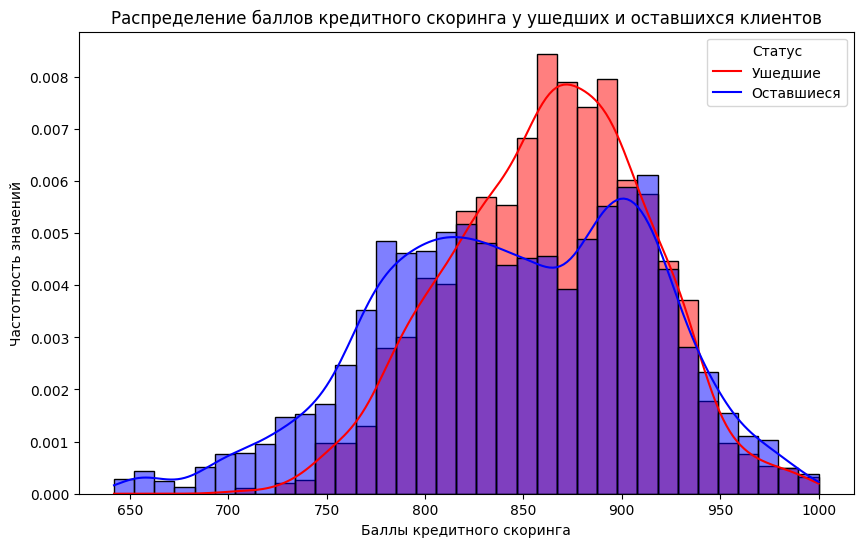

In [25]:
# Задаем размеры гистограммы
plt.figure(figsize=(10, 6))

# Строим гистограмму с нормализованными плотностями для каждой группы
sns.histplot(data=data, x='score', hue='churn', kde=True, 
             stat="density", common_norm=False, 
             palette={0: 'blue', 1: 'red'}, 
             alpha=0.5,
             bins = 35)

# Добавляем заголовок и подписи осей
plt.title('Распределение баллов кредитного скоринга у ушедших и оставшихся клиентов')
plt.xlabel('Баллы кредитного скоринга')
plt.ylabel('Частотность значений')
plt.legend(title='Статус', labels=['Ушедшие', 'Оставшиеся'])

# Показываем график
plt.show()

Судя по гистограмме чаще остаются клиенты, чьи баллы кредитного скоринга не превышают 820. **Наиболее склонны к оттоку клиенты с кредитным скорингом от 820 до 920 баллов**. Можно предположить, что клиенты с относительно низким скорингом не чувстствуют себя достаточно уверенно в материальном плане для смены банка, а клиенты с скорингом свыше 920 баллов давно являются клиентами банка и удовлетворены условиями. Клиенты со средними баллами, с одной стороны, достаточно уверены в своем материальном положении, чтобы рассчитывать на более выгодные условия в других банках, а с другой стороны не так лояльны выбранном банку поскольку получают не так много преференций как клиенты с самыми высокими баллами. 

**Age (возраст)**

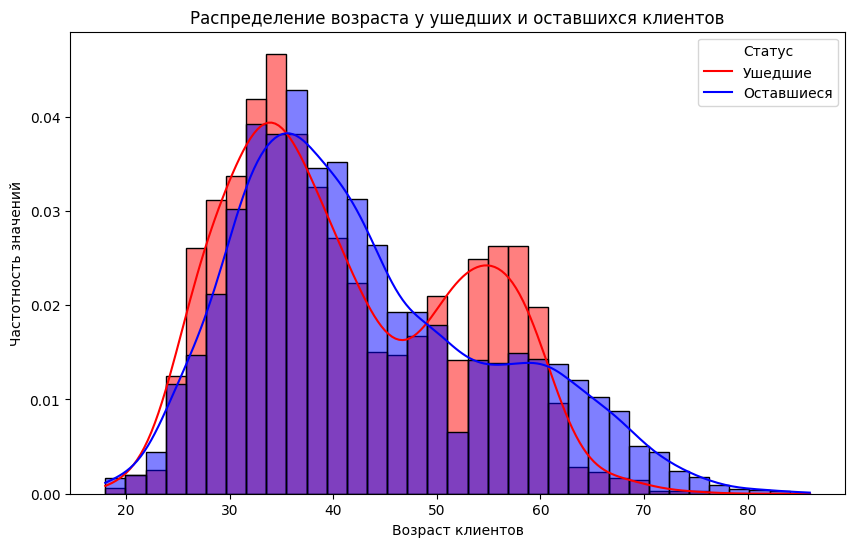

In [26]:
# Задаем размеры гистограммы
plt.figure(figsize=(10, 6))

# Строим гистограмму с нормализованными плотностями для каждой группы
sns.histplot(data=data, x='age', hue='churn', kde=True, 
             stat="density", common_norm=False, 
             palette={0: 'blue', 1: 'red'}, 
             alpha=0.5, 
             bins = 35)

# Добавляем заголовок и подписи осей
plt.title('Распределение возраста у ушедших и оставшихся клиентов')
plt.xlabel('Возраст клиентов')
plt.ylabel('Частотность значений')
plt.legend(title='Статус', labels=['Ушедшие', 'Оставшиеся'])

# Показываем график
plt.show()

На данной гистограмме следует обратить внимание, что **наиболее склонными к оттоку являются клиенты в возрасте от 50 до 60 лет**. Также к оттоку более склонны молодые клиенты в возрастном диапазоне от 25 до 35 лет (самая многочисленная доля клиентов). В то время как доля отточных клиентов снижается в диапазонах от 35 до 50 лет, а также в диапазоне после 60 лет. Можно предположить, что у банка есть достаточно привлекательные предложений для клиентов пенсионного возраста, однако мало интересных предложений для клиентов с значительным накопленным капиталом, к которым часто относятся клиенты в возрасте 50-60 лет. 

**Balance (баланс всех следств клиента)**

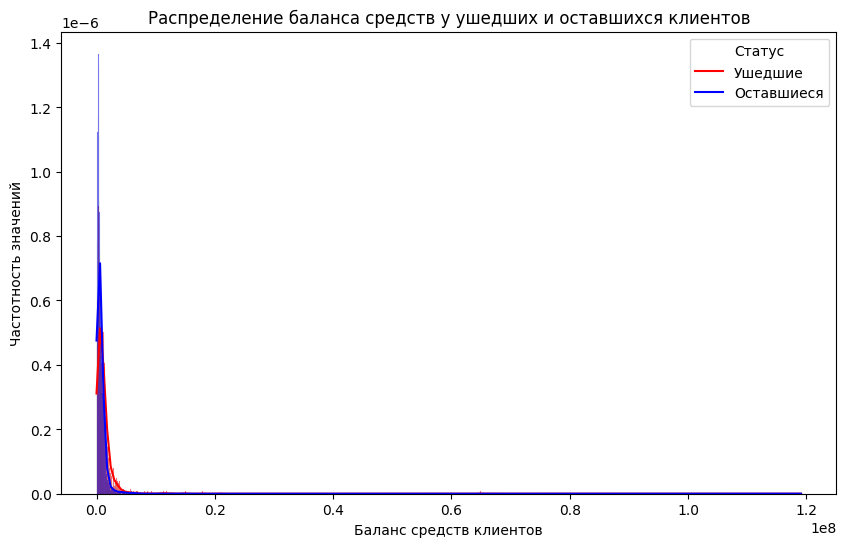

In [27]:
# Задаем размеры гистограммы
plt.figure(figsize=(10, 6))

# Строим гистограмму с нормализованными плотностями для каждой группы
sns.histplot(data=data, x='balance', hue='churn', kde=True, 
             stat="density", common_norm=False, 
             palette={0: 'blue', 1: 'red'}, 
             alpha=0.5)

# Добавляем заголовок и подписи осей
plt.title('Распределение баланса средств у ушедших и оставшихся клиентов')
plt.xlabel('Баланс средств клиентов')
plt.ylabel('Частотность значений')
plt.legend(title='Статус', labels=['Ушедшие', 'Оставшиеся'])

# Показываем график
plt.show()

In [28]:
# Расчитаем процент потери данных и при заданном значении баланса средств клиентов
percentage = (data.loc[data['balance'] > 4000000]['balance'].count() / data['balance'].count()) * 100
percentage_rounded = round(percentage, 2)
print(f'Процент потери данных: {percentage_rounded} %')

# Выведим долю этих данных от общего объема баланса средств клиентов
balance_share = (data.loc[data['balance'] > 4000000]['balance'].sum() / data['balance'].sum()) * 100
balance_rounded = round(balance_share, 2)
print(f'Доля от общего объема данных: {balance_rounded} %')

Процент потери данных: 1.45 %
Доля от общего объема данных: 16.53 %


При построении гистограммы обнаружены значительные выбросы значений. Так баланс средств полутора процентов клиентов с показателем свыше 4 млн. составляет почти 17% средств от общего объема, что приведет к значительному влиянию выбросов при дальнейшем анализе. В этой связи решено отбросить данные клиентов с балансом средств свыше 4 млн. и заново построить гистограмму. 

In [29]:
data_filtered = data.loc[data['balance'] <= 4000000]

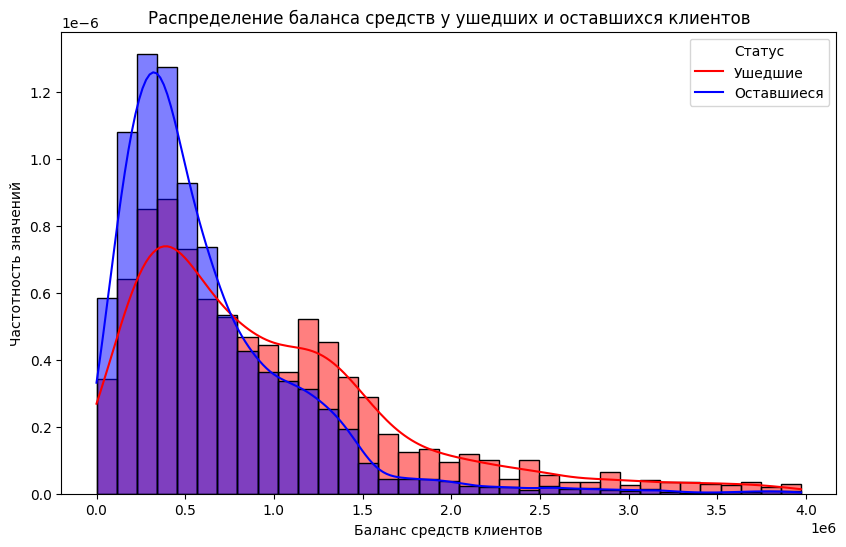

In [30]:
# Задаем размеры гистограммы
plt.figure(figsize=(10, 6))

# Строим гистограмму с нормализованными плотностями для каждой группы
sns.histplot(data=data_filtered, x='balance', hue='churn', kde=True, 
             stat="density", common_norm=False, 
             palette={0: 'blue', 1: 'red'}, 
             alpha=0.5, 
             bins = 35)

# Добавляем заголовок и подписи осей
plt.title('Распределение баланса средств у ушедших и оставшихся клиентов')
plt.xlabel('Баланс средств клиентов')
plt.ylabel('Частотность значений')
plt.legend(title='Статус', labels=['Ушедшие', 'Оставшиеся'])

# Показываем график
plt.show()

**Клиенты, баланс которых превышает 750 тысяч, имеют большую тенденцию к оттоку** по сравнению с другими клиентами. Клиенты, чей баланс не превысил указанную выше сумму, стабильно чаще склонны проявлятть лояльность к выбранному банку. 

**Est_salary (оценочный размер заработной платы клиента)**

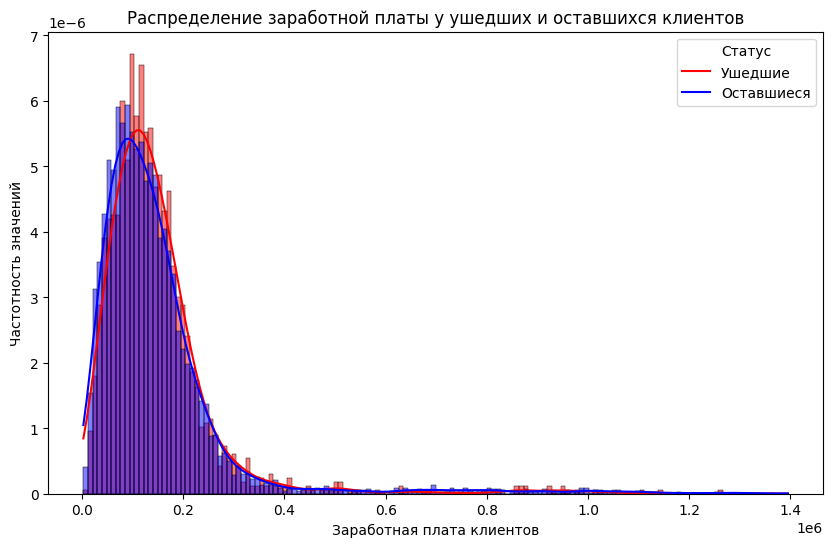

In [31]:
# Задаем размеры гистограммы
plt.figure(figsize=(10, 6))

# Строим гистограмму с нормализованными плотностями для каждой группы
sns.histplot(data=data, x='est_salary', hue='churn', kde=True, 
             stat="density", common_norm=False, 
             palette={0: 'blue', 1: 'red'}, 
             alpha=0.5)

# Добавляем заголовок и подписи осей
plt.title('Распределение заработной платы у ушедших и оставшихся клиентов')
plt.xlabel('Заработная плата клиентов')
plt.ylabel('Частотность значений')
plt.legend(title='Статус', labels=['Ушедшие', 'Оставшиеся'])

# Показываем график
plt.show()

In [32]:
# Расчитаем процент потери данных и при заданном значении заработной платы клиентов
percentage_salary = (data.loc[data['est_salary'] > 400000]['est_salary'].count() / data['est_salary'].count()) * 100
percentage_salary_rounded = round(percentage_salary, 2)
print(f'Процент потери данных: {percentage_salary_rounded} %')

# Выведим долю этих данных от общего объема заработной платы клиентов
salary_share = (data.loc[data['est_salary'] > 400000]['est_salary'].sum() / data['est_salary'].sum()) * 100
salary_share_rounded = round(salary_share , 2)
print(f'Доля от общего объема данных: {salary_share_rounded} %')

Процент потери данных: 3.37 %
Доля от общего объема данных: 17.11 %


В данных о распределении заработной платы также наблюдаются выбросы. Если взять данные исходного датафрейма, то чуть более 3% клиентов зарабатывают более 17% от общего объема заработной платы. Уберем данные об этих клиентах, добавив условия для фильтрации датафрейма и заново построим гистограмму.

In [33]:
data_filtered = data.loc[data['est_salary'] <= 400000]

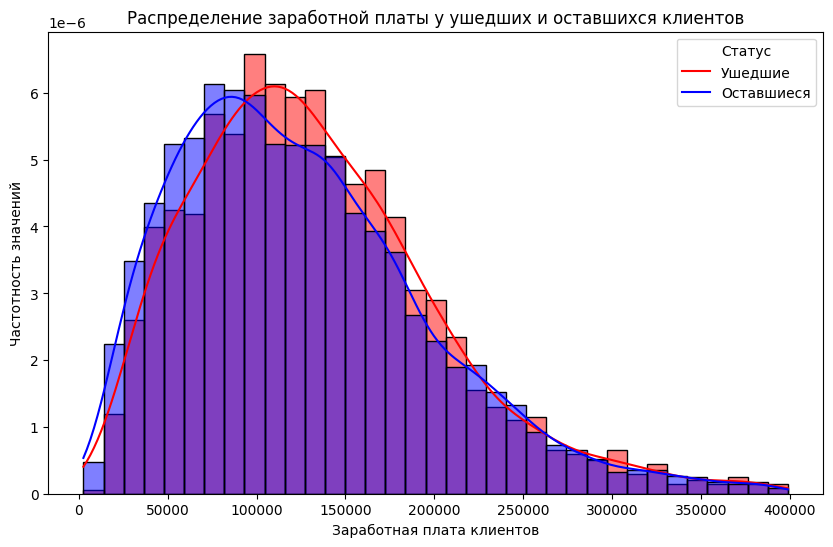

In [34]:
# Задаем размеры гистограммы
plt.figure(figsize=(10, 6))

# Строим гистограмму с нормализованными плотностями для каждой группы
sns.histplot(data=data_filtered, x='est_salary', hue='churn', kde=True, 
             stat="density", common_norm=False, 
             palette={0: 'blue', 1: 'red'}, 
             alpha=0.5, 
             bins = 35)

# Добавляем заголовок и подписи осей
plt.title('Распределение заработной платы у ушедших и оставшихся клиентов')
plt.xlabel('Заработная плата клиентов')
plt.ylabel('Частотность значений')
plt.legend(title='Статус', labels=['Ушедшие', 'Оставшиеся'])

# Показываем график
plt.show()

**Более склонны к оттоку клиенты с заработной платой приблизительно от 85 тысяч до 230 тысяч**. Клиенты, предположительно зарабатывающие меньше этой суммы ежемесячно, в целом более склонны оставаться лояльными выбранному банку, хотя стоит отметить, что по данному показателю разница не столь значительна. 

### Анализ распределения для категориальных признаков

Теперь проведем анализ распределения для категориальных признаков, данные о которых содержатся в столбцах `city`, `gender`, `equity`, `products`, `credit_card`, `last_activity`, `balance_stated`.

**City (место расположения филиала банка, к которому относится клиент)**

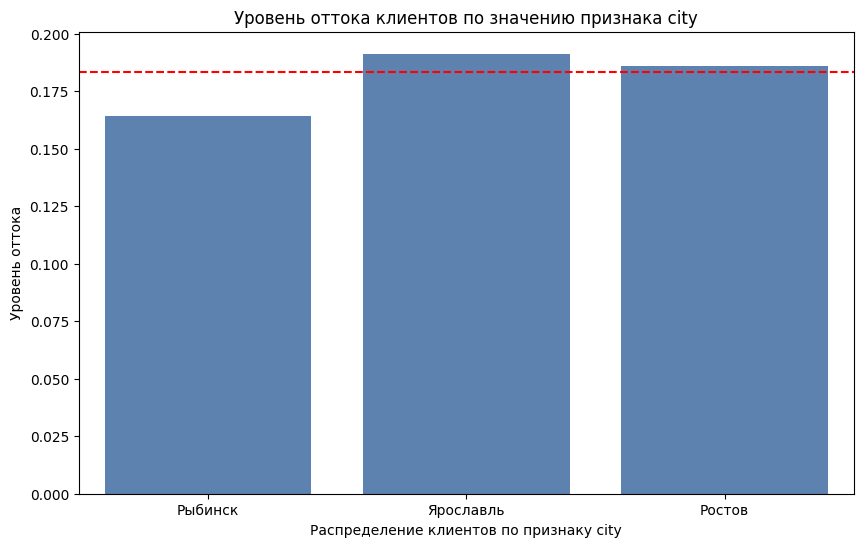

In [35]:
# Вычисляем общий процент оттока по банку
overall_churn_rate = data_filtered['churn'].mean()

# Функция для создания диаграммы с уровнем оттока
def plot_churn_by_feature(data, feature, overall_churn_rate):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature, y='churn', data=data, color='#4f81bd', errorbar=None)
    plt.axhline(overall_churn_rate, color='red', linestyle='--')
    plt.title(f'Уровень оттока клиентов по значению признака {feature}')
    plt.xlabel(f'Распределение клиентов по признаку {feature}')
    plt.ylabel('Уровень оттока')
    plt.show()

# Пример вызова функции для конкретного столбца
plot_churn_by_feature(data_filtered, 'city', overall_churn_rate)

Уровень оттока клиентов в Ярославле выше среднего по банку, в Ростове - практически равно среднему значению, в Рыбинске - ниже чем в среднем по банку и в остальных двух филиалах. 

**Gender (пол клиента)**

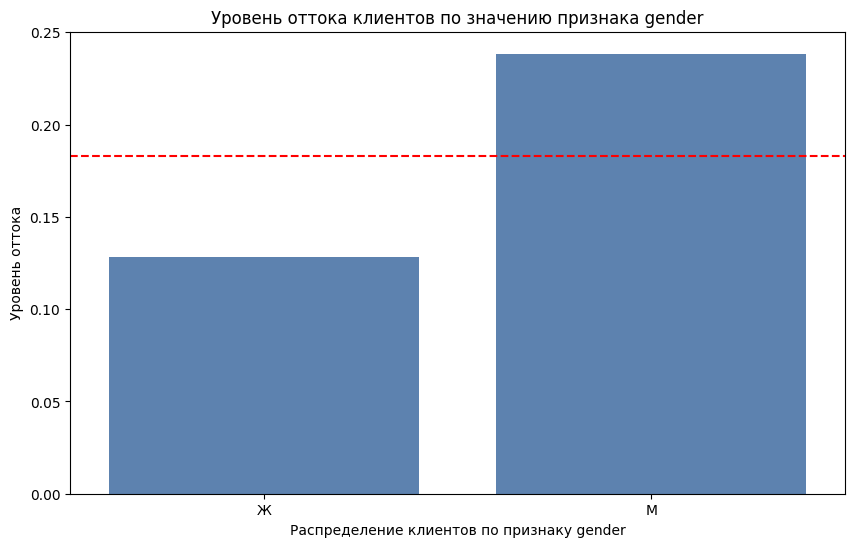

In [36]:
plot_churn_by_feature(data_filtered, 'gender', overall_churn_rate)

Клиенты-мужчины в значительно большей степени склонны к оттоку, чем клиенты-женщины. Показатель мужчин также значительно превышает средний отток по банку. 

**Equity (количество единиц собственности клиента)**

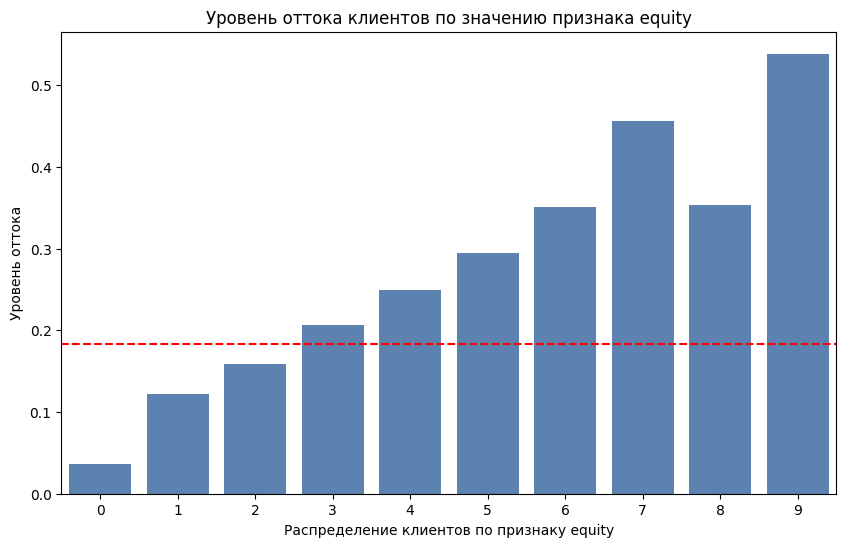

In [37]:
plot_churn_by_feature(data_filtered, 'equity', overall_churn_rate)

Клиенты, владеющие тремя и более единицами собственности, более склонны к оттоку, чем в среднем по банку. За единственным исключением, чем больше собственности у клиента, тем ниже его лояльность выбранному банку. 

**Products (количество продуктов банка, которыми пользуется клиент)**

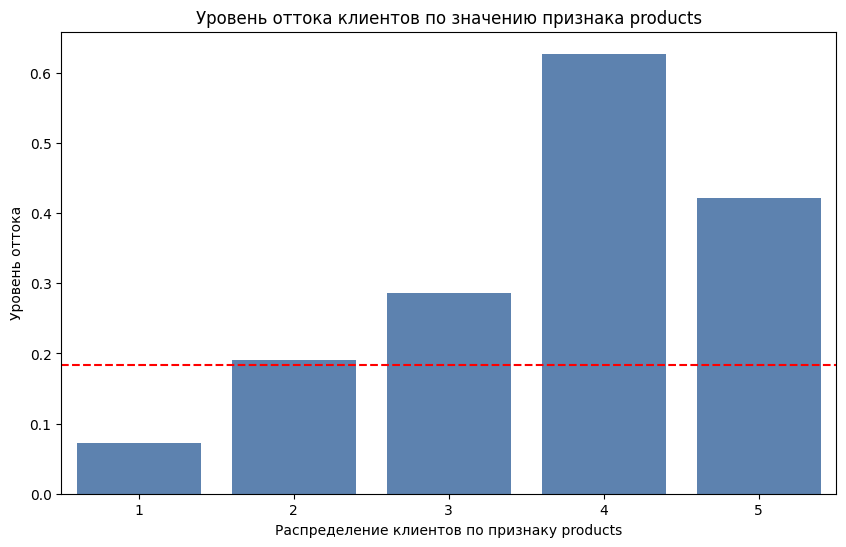

In [38]:
plot_churn_by_feature(data_filtered, 'products', overall_churn_rate)

Наибольший уровень оттока наблюдается у клиентов, пользующихся 4 банковскими продуктами. Также уровень оттока выше среднего по банку демонстрируют клиенты с 3 и 5 продуктами, клиенты с 2 продуктами имеют показатель, практически равный среднему. Можно предположить, что среди клиентов с одним продуктом есть значительная доля зарплатных клиентов. 

**Credit_card (наличие у клиента кредитной карты: 1 - есть, 0 - нет)**

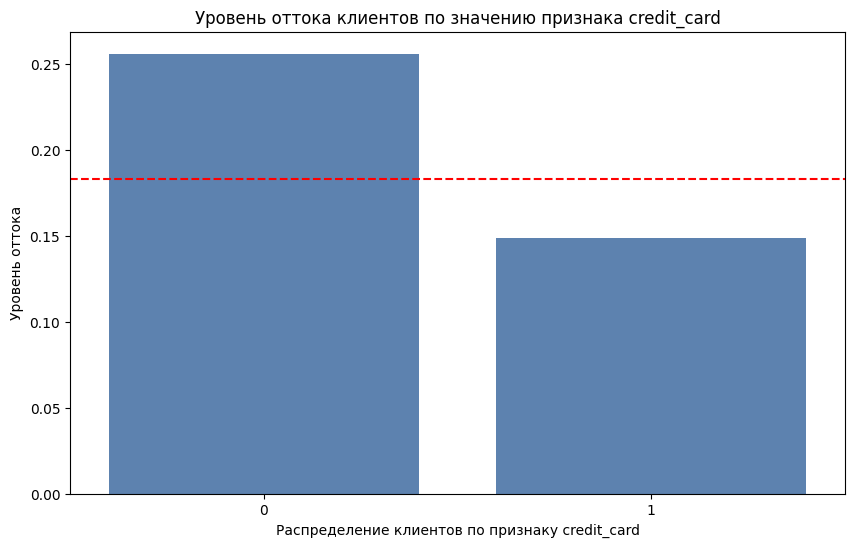

In [39]:
plot_churn_by_feature(data_filtered, 'credit_card', overall_churn_rate)

Клиенты, не имеющие кредитных карт, более склонны к оттоку, нежели их обладатели. 

**Last_activity (активность клиента за фиксированный промежуток времени: 1 - активен, 0 - не активен)**

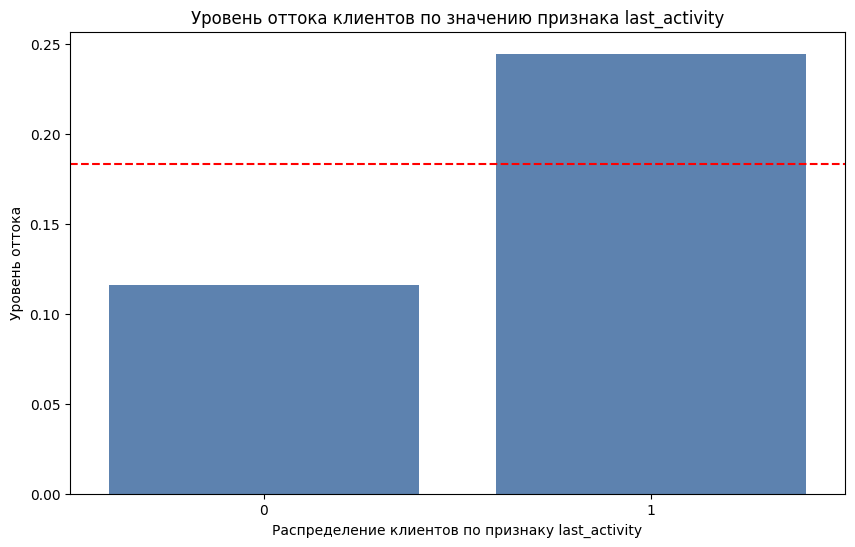

In [40]:
plot_churn_by_feature(data_filtered, 'last_activity', overall_churn_rate)

Уровень оттока активных клиентов выше среднего значения, неактивных - ниже. Можно предположить, что среди неактивных за последний временной промежуток клиентов есть как те, кто оформил банковский продукт, но не пользуется им, так и те, кто пользуется долгосрочными продуктами, например, банковскими вкладами на большой срок. 

**Balance_missing (отсутствие информации о балансе клиента: 1 - данные о балансе отсутствуют, 0 - данные о балансе указаны)**

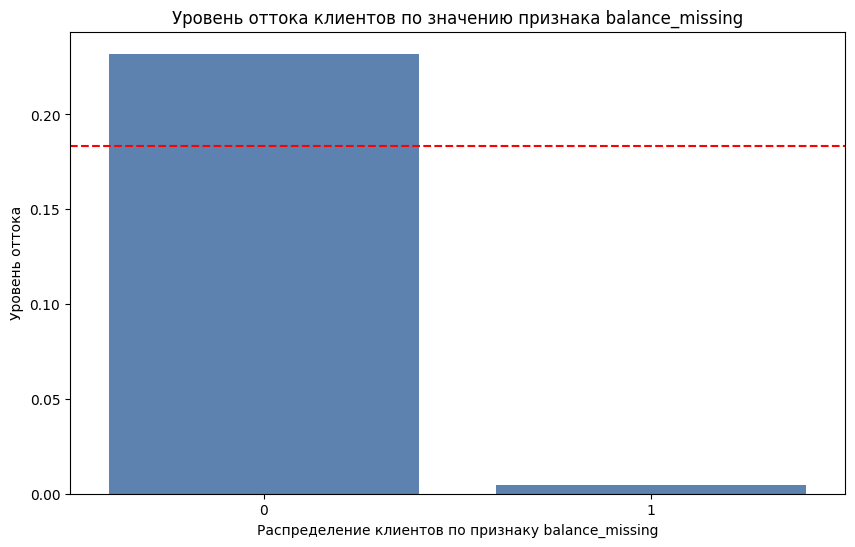

In [41]:
plot_churn_by_feature(data_filtered, 'balance_missing', overall_churn_rate)

Клиенты, для которых не указаны данные о балансе средств, практически не склонны к оттоку, подавляющее большинство отточных клиентов имеют обозначенный в датафрейме баланс средств. 

### Корреляционный анализ

Построим матрицу корреляции прочих признаков с признаком оттока клиентов путем метода `corr()`. 

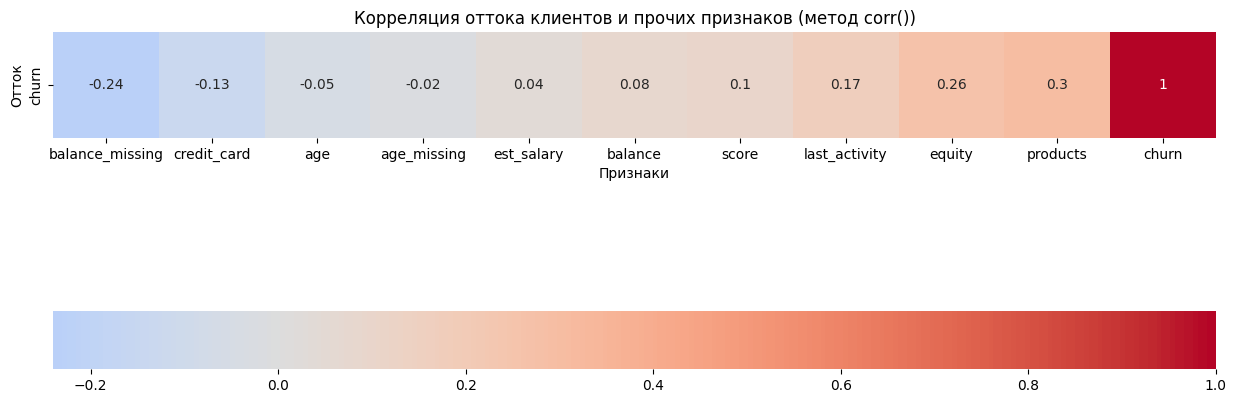

In [42]:
# Отфильтруем только числовые столбцы, уберем столбец user_id
numeric_data = data_filtered.drop(columns=['user_id']).select_dtypes(include=[float, int])

# Построим корреляционную матрицу
corr_m = numeric_data.corr()

# Выводим корреляцию столбца 'churn' с остальными столбцами
corr_churn = corr_m['churn']

# Отсортируем значения корреляции по убыванию
corr_churn = corr_churn.sort_values()

# Транспонируем таблицу для удобства отображения
corr_churn = corr_churn.to_frame().T

# Округлим значения чисел до двух знаков после разделителя
corr_churn = corr_churn.round(2)

# Создаем фигуру для heatmap
plt.figure(figsize=(15, 15))

# Рисуем heatmap с горизонтально расположенной шкалой
sns.heatmap(corr_churn, square=True, annot=True, cmap='coolwarm', cbar_kws={'orientation': 'horizontal'}, center=0)

# Настройка графика
plt.title('Корреляция оттока клиентов и прочих признаков (метод corr())')
plt.xlabel('Признаки')
plt.ylabel('Отток')

# Показываем график
plt.show()

Построим матрицу корреляции прочих признаков с признаком оттока клиентов путем метода `phik()`. 

In [43]:
# Вычисляем матрицу 'phik'
phik_overview = data_filtered.drop(columns=['user_id']).phik_matrix(interval_cols=['age', 
                                                                                   'score', 
                                                                                   'balance', 
                                                                                   'est_salary'])

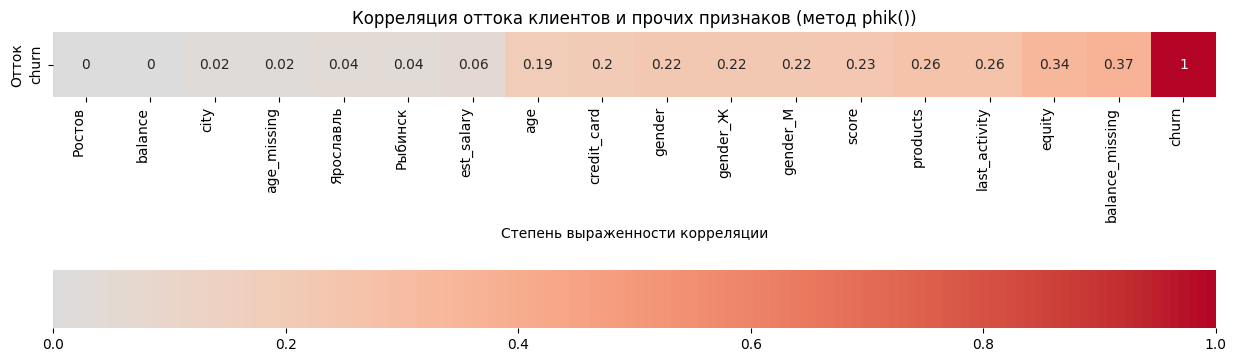

In [44]:
# Извлекаем строку 'churn' и сортируем по значениям корреляции, транспонируем таблицу для удобства отображения
churn_row = phik_overview.loc['churn'].sort_values(ascending=True).to_frame().T

# Округлим значения чисел до двух знаков после разделителя
churn_row = churn_row.round(2)

# Создаем heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(churn_row, square=True, annot=True, cmap='coolwarm', cbar_kws={'orientation': 'horizontal'}, center=0)

# Настройка графика
plt.title('Корреляция оттока клиентов и прочих признаков (метод phik())')
plt.xlabel('Степень выраженности корреляции')
plt.ylabel('Отток')
plt.xticks(rotation=90, ha='right')
plt.show()

Порядок корреляции признаков в двух матрицах различается, однако можно выдеть общие тенденции. Так топ-4 по степени влияния на отток клиентов в обеих матрицах занимают параметры указания баланса средств (`balance_missing`, негативная корреляция), количества единиц собственности (`equity`), активности клиентов (`last_activity`), количества банковских продуктов у клиента (`products`).
Если ориентироваться на матрицу корреляции, построенную при помощи метода `phik()`, то по шкале Чеддока можно дать следующую качественную характеристику силы связи между отдельными параметрами и отоком клиентов банка:
- весьма высокой, высокой и заметной связи не наблюдается;
- умеренная связь (0,3-0,5) оттока клиентов имеется с признаками `balance_missing` и `equity`;
- слабая связь (0,1-0,3) оттока клиентов имеется с признаками `last_activity`,  `products`, `score`, `gender`, `credit_card` и `age`. 

### Составление портрета клиента в разрезе оттока

Составим портрет клиента в разрезе оттока, а также посчитаем относительную разницу разницу между отточными и неотточными клиентами. 

In [45]:
# Сегменты 'Ушедшие клиенты' и 'Оставшиеся клиенты'
churn_segment = data_filtered[data_filtered['churn'] == 1]
non_churn_segment = data_filtered[data_filtered['churn'] == 0]

# Функция для подсчета относительной разницы
def calculate_relative_difference(value_churn, value_non_churn):
    relative_difference = ((value_churn - value_non_churn) / value_non_churn * 100).round(2)
    return f'{relative_difference} %'

# Создаем таблицу для сбора результатов
results = pd.DataFrame(columns=['Ушедшие клиенты', 'Оставшиеся клиенты', 'Относительная разница'])

# Средний балл кредитного скоринга
mean_score_churn = (churn_segment['score'].mean()).round(2)
mean_score_non_churn = (non_churn_segment['score'].mean()).round(2)
relative_difference_score = calculate_relative_difference(mean_score_churn, mean_score_non_churn)
results.loc['Средний балл кредитного скоринга'] = [mean_score_churn, 
                                                   mean_score_non_churn, 
                                                   relative_difference_score]

# Средний возраст
mean_age_churn = (churn_segment['age'].mean()).round(2)
mean_age_non_churn = (non_churn_segment['age'].mean()).round(2)
relative_difference_age = calculate_relative_difference(mean_age_churn, mean_age_non_churn)
results.loc['Средний возраст'] = [mean_age_churn, 
                                  mean_age_non_churn, 
                                  relative_difference_score]

# Средний баланс средств
mean_balance_churn = (churn_segment['balance'].mean()).round(2)
mean_balance_non_churn = (non_churn_segment['balance'].mean()).round(2)
relative_difference_balance_mean = calculate_relative_difference(mean_balance_churn, mean_balance_non_churn)
results.loc['Средний баланс средств'] = [mean_balance_churn, 
                                         mean_balance_non_churn, 
                                         relative_difference_balance_mean]

# Медианный баланс средств
median_balance_churn = (churn_segment['balance'].median()).round(2)
median_balance_non_churn = (non_churn_segment['balance'].median()).round(2)
relative_difference_balance_median = calculate_relative_difference(median_balance_churn, median_balance_non_churn)
results.loc['Медианный баланс средств'] = [median_balance_churn, 
                                           median_balance_non_churn, 
                                           relative_difference_balance_median]

# Средняя зарплата
mean_salary_churn = (churn_segment['est_salary'].mean()).round(2)
mean_salary_non_churn = (non_churn_segment['est_salary'].mean()).round(2)
relative_difference_salary_mean = calculate_relative_difference(mean_salary_churn, mean_salary_non_churn)
results.loc['Средняя зарплата'] = [mean_salary_churn, 
                                   mean_salary_non_churn, 
                                   relative_difference_salary_mean]

# Медианная зарплата
median_salary_churn = (churn_segment['est_salary'].median()).round(2)
median_salary_non_churn = (non_churn_segment['est_salary'].median()).round(2)
relative_difference_salary_median = calculate_relative_difference(mean_salary_churn, mean_salary_non_churn)
results.loc['Медианная зарплата'] = [median_salary_churn, 
                                     median_salary_non_churn, 
                                     relative_difference_salary_median]

# Медианное количество продуктов
median_products_churn = churn_segment['products'].median()
median_products_non_churn = non_churn_segment['products'].median()
relative_difference_products = calculate_relative_difference(median_products_churn, median_products_non_churn)
results.loc['Медианное количество продуктов'] = [median_products_churn, 
                                                 median_products_non_churn, 
                                                 relative_difference_products]

# Медианное количество собственности
median_equity_churn = churn_segment['equity'].median()
median_equity_non_churn = non_churn_segment['equity'].median()
relative_difference_equity = calculate_relative_difference(median_equity_churn, median_equity_non_churn)
results.loc['Медианное количество собственности'] = [median_equity_churn, 
                                                     median_equity_non_churn, 
                                                     relative_difference_equity]

# Мода по городу
mode_city_churn = churn_segment['city'].mode()[0]
mode_city_non_churn = non_churn_segment['city'].mode()[0]
results.loc['Мода по городу'] = [mode_city_churn, mode_city_non_churn, '']

# Мода по полу
mode_gender_churn = churn_segment['gender'].mode()[0]
mode_gender_non_churn = non_churn_segment['gender'].mode()[0]
results.loc['Мода по полу'] = [mode_gender_churn, mode_gender_non_churn, '']

results

,Ушедшие клиенты,Оставшиеся клиенты,Относительная разница
Средний балл кредитного скоринга,861.61,844.45,2.03 %
Средний возраст,41.47,43.01,2.03 %
Средний баланс средств,1016808.57,673097.9,51.06 %
Медианный баланс средств,765946.34,470699.76,62.73 %
Средняя зарплата,132410.31,125613.08,5.41 %
Медианная зарплата,122451.5,115096.72,5.41 %
Медианное количество продуктов,2.0,2.0,0.0 %
Медианное количество собственности,4.0,3.0,33.33 %
Мода по городу,Ярославль,Ярославль,
Мода по полу,М,Ж,


По получившемуся портрету клиента видно, что максимальный разрыв между оточными и неоточными клиентами наблюдается в таких параметрах как баланс средств и количество собственности. Также стоит отметить, что мужчины чаще склонны уходит из банка, в то время как женщины чаще попадают в долю неотточных клиентов. Можно сказать, что банк не просто столкнулся с увеличением оттока клиентов: среди отточных клиентов преобладают наиболее обеспеченные и надежные клиенты банка. 

**В целом по результатам исследовательского анализа данных** можно сказать, что на отток клиентов сильнее всего влияют такие параметры как количество собственности и банковских продуктов в распоряжении клиента, а также его активность. 
При этом в целом отток клиентов происходит преимущественно среди людей с высоким кредитным скорингом, в возрастном диапазоне от 35 до 50, а также от 50 до 60 лет, баланс средств которых превышает 750 тысяч, а заработная плата варьируется в пределах от 85 до 230 тысяч.

Также стоит отметить, что среди склонных к оттоку преобладают клиенты  со следующими признаками: мужчины, место банковского обслуживания – Ярославль, с количеством собственности от 3 единиц и выше, пользующиеся тремя и более банковскими продуктами, не имеющие кредитную карту, открытую в данном банке и активные, то есть совершавшие какие-либо действия по пользованию банковскими продуктами за последнее фиксированное время.

## Формулирование и проверка статистических гипотез 

Проверим две гипотезы о наличии статистически значимой разницы средних заработных плат и среднего возраста для ушедших и оставшихся клиентов банка. 

### Проверка гипотезы о равенстве заработной платы (с обоснованием выбора статистического теста) 

Средняя заработная плата ушедших клиентов составляет 132 410.31, средняя заработная плата оставшихся клиентов - 125 613.08. Проверим, насколько статистически значимой является данная разница. 

Поскольку совокупности заработных плат ушедших и оставшихся клиентов не зависят друг от друга, а размер обеих выборок достаточно велик (7893 ушедших и 1769 оставшихся), можно было бы рассмотреть возможность применения t-теста для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, однако предварительно необходимо проверить, есть ли в отфильтрованных данных значительные выбросы, к которым чувствителен t-тест. 

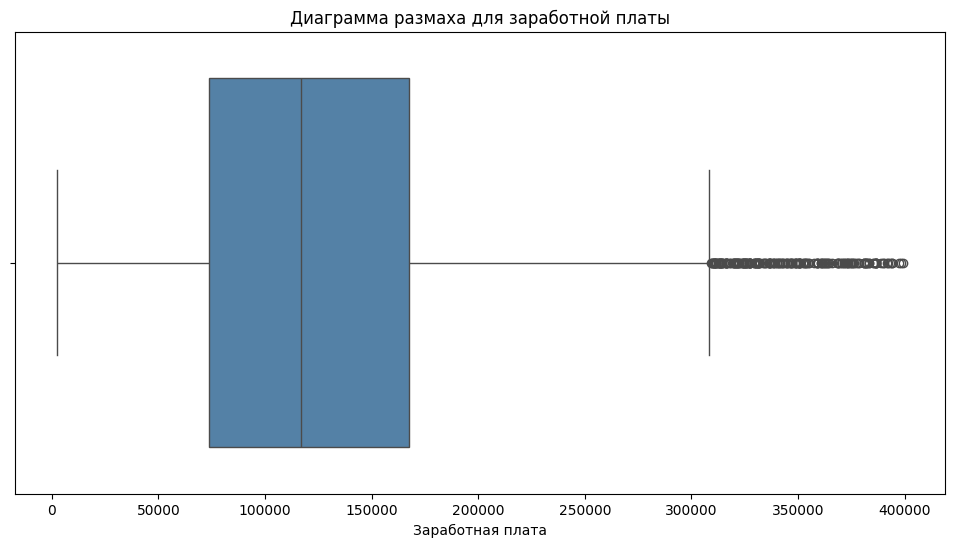

In [46]:
# Создаем диаграмму размаха 
plt.figure(figsize=(12, 6))
sns.boxplot(x=data_filtered['est_salary'], color='steelblue')

# Настройки графика
plt.title('Диаграмма размаха для заработной платы')
plt.xlabel('Заработная плата')

# Показываем график
plt.show()

Поскольку в данных по заработной плате все равно остались значительные выбросы, придется отказаться от проведения t-теста в пользу непараметрического тест Манна-Уитни (st.mannwhitneyu()):

**Нулевая гипотеза:** Средние заработные плата ушедших и оставшихся клиентов банка равны.

**Альтернативная гипотеза:** Средние заработные плата ушедших и оставшихся клиентов банка не равны.

In [47]:
salary_churn = data_filtered.loc[data_filtered['churn'] == 1]['est_salary']
salary_non_churn = data_filtered.loc[data_filtered['churn'] == 0]['est_salary']

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.mannwhitneyu(salary_churn, salary_non_churn) 

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
     print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя')

p-значение:  9.371616928434134e-06
Отвергаем нулевую гипотезу: разница статистически значима


По результатам проведенного теста Манна-Уитни удалось отвергнуть нулевую гипотезу о равенстве средних заработных плат ушедших и оставшихся клиентов банка, следовательно между показателями средних заработных план у ушедших и оставшихся клиентов есть статистически значимая разница.

### Проверка гипотезы о равенстве возрастов (с обоснованием выбора статистического теста) 

Средний возраст ушедших клиентов составляет 41.5 год, средний возраст оставшихся клиентов - 43 года. Проверим, является ли разница в возрасте у двух типов клиентов статистически значимой.

Совокупности возрастов ушедших и оставшихся клиентов не зависят друг от друга, а размер обеих выборок достаточно велик (7893 ушедших и 1769 оставшихся), поэтому для проверки возможности использования t-теста необходимо проверить, есть ли в отфильтрованных данных значительные выбросы, к которым чувствителен t-тест. 

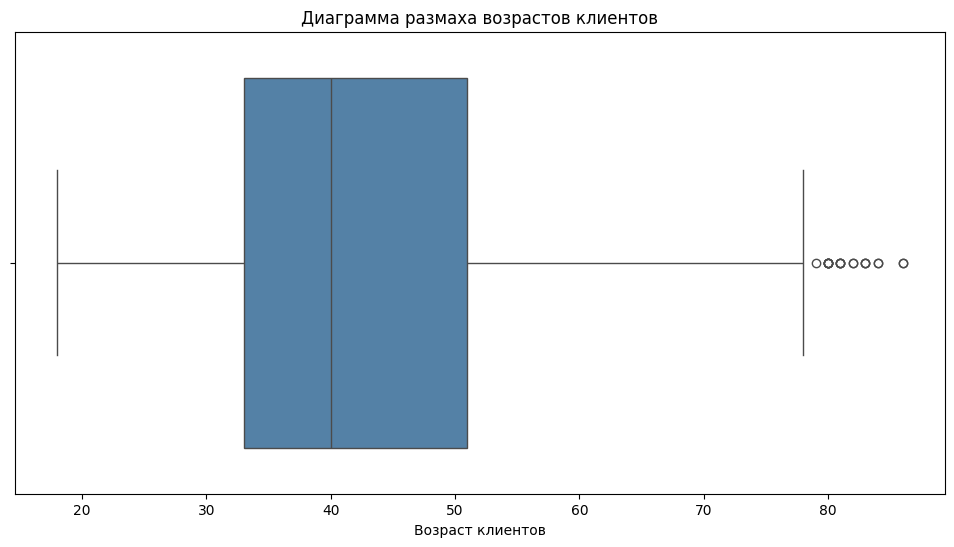

In [48]:
# Создаем диаграмму размаха 
plt.figure(figsize=(12, 6))
sns.boxplot(x=data_filtered['age'], color='steelblue')

# Настройки графика
plt.title('Диаграмма размаха возрастов клиентов')
plt.xlabel('Возраст клиентов')

# Показываем график
plt.show()

Выбросов немного, для их фильтрации ограничим данные по возрасту 95 перцентилем:

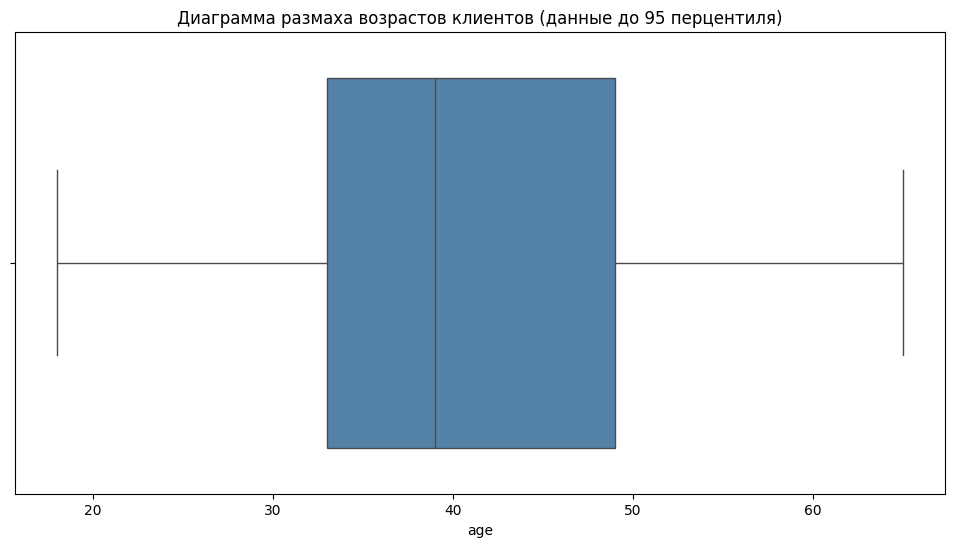

In [49]:
# Определяем верхний порог по 95-му перцентилю
age_threshold = np.percentile(data_filtered['age'], 95)

# Отфильтровываем данные, оставляя только те, которые находятся в пределах 95-го перцентиля
data_filtered = data_filtered[data_filtered['age'] <= age_threshold]

# Создаем вертикальную диаграмму размаха с отфильтрованными данными
plt.figure(figsize=(12, 6))
sns.boxplot(x=data_filtered['age'], color='steelblue')

# Настройки графика
plt.title('Диаграмма размаха возрастов клиентов (данные до 95 перцентиля)')
plt.xlabel('age')

# Показываем график
plt.show()

Теперь применим t-тест для провеки гипотез. Поскольку размер выборок в достаточной мере различается (более чем в 4 раза), установим для параметра `equal_var` значение `False`, чтобы тест посчитал дисперсии выборок по отдельности.

**Нулевая гипотеза:** Возрасты ушедших и оставшихся клиентов банка равны.

**Альтернативная гипотеза:** Возрасты ушедших и оставшихся клиентов банка не равны.

In [50]:
age_churn = data_filtered.loc[data_filtered['churn'] == 1]['age']
age_non_churn = data_filtered.loc[data_filtered['churn'] == 0]['age']

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(age_churn, age_non_churn, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
     print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя')

p-значение: 0.7304786818230781
Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя


По результатам проведенного t-теста удалось отвергнуть нулевую гипотезу о равенстве возрастов ушедших и оставшихся клиентов банка, следовательно между показателями возраста у ушедших и оставшихся клиентов есть статистически значимая разница. 

**Проведенные проверки гипотез показали**, что даже разница в 6800 в заработной плате и 1,5 года в возрасте у ушедших и оставшихся клиентов банка является статистически значимой в рамках анализируемого датафрейма. 

## Подведение промежуточных итогов анализа

По результатам проведения анализа распределения для непрерывных и категориальных признаков, корреляционного анализа, построения портрета ушедших и оставшихся клиентов, проверки гипотез о статистической значимости разницы отдельных параметров можно сделать вывод о том, что для дальнейшей сегментации клиентов банка с целью выделения групп клиентов, наиболее склонных к оттоку, необходимо ориентироваться на следующие отточные интервалы и категории (в порядке убывания приоритета):

- количество единиц собственности: 3 и более;
- активность клиента: активный за оцениваемый интервал времени;
- количество продуктов банка, используемых клиентом: 3 и более;
- количество баллов кредитного скоринга: от 820 до 920 (с пиком в районе 850-900 баллов);
- пол: мужчина;
- кредитная карта банка: отсутствует;
- возраст: от 25 до 35 лет, от 50 до 60 лет;
- оценочный размер заработной платы: от 85 до 230 тысяч;
- город проживания: Ярославль;
- баланс средств: свыше 750 тысяч.

## Сегментация клиентов банка

**Цель сегментации:** выделить из общего объема клиентов банка сегменты, в которых количество клиентов превышает 500 человек, а уровень оттока выше, чем в среднем по банку (18%), для формирования рекомендаций отделу маркетинга по таргетированной работе с такими клиентами для снижения оттока. 

In [51]:
# Выделяем сегменты клиентов и добавляем их описание
segments = {
    "Сегмент 1": {
        "data": data_filtered.loc[(data_filtered['balance'] > 750000) & (data_filtered['credit_card'] == 0) &\
        (data_filtered['last_activity'] == 1)],
        "description": "Баланс > 750000, кредитная карта отсутствует, активный клиент"
    },
    "Сегмент 2": {
        "data": data_filtered.loc[((data_filtered['age'] >= 50) & (data_filtered['age'] <= 60)) &\
        (data_filtered['gender'] == 'М') & (data_filtered['products'] > 1)],
        "description": 'Возраст 50-60, пол "М", более 1 продукта'
    },
    "Сегмент 3": {
        "data": data_filtered.loc[((data_filtered['score'] >= 850) & (data_filtered['score'] <= 900)) &\
        (data_filtered['city'] == 'Ярославль') & (data_filtered['equity'] >= 3)],
        "description": "Кредитный скоринг 850-900 баллов, г. Ярославль, 3 и более единиц собственности"
    }
}

# Подготавливаем данные для сводной таблицы
summary_data = []

for segment_name, segment_info in segments.items():
    segment_data = segment_info["data"]
    segment_description = segment_info["description"]
    segment_count = segment_data['user_id'].count()
    churn_rate = ((segment_data.loc[segment_data['churn'] == 1]['user_id'].count() / segment_count) * 100)\
                 .round(2) if segment_count > 0 else 0
    summary_data.append({
        'Сегмент': segment_name,
        'Условия': segment_description,
        'Количество клиентов': segment_count,
        'Уровень оттока (%)': churn_rate
    })

# Создаем сводную таблицу
summary_df = pd.DataFrame(summary_data)

# Сортируем по уровню оттока
summary_df = summary_df.sort_values(by='Уровень оттока (%)', ascending=False)

# Сбрасываем индекс и устанавливаем новый начиная с 1
summary_df = summary_df.reset_index(drop=True)
summary_df.index = summary_df.index + 1

summary_df

,Сегмент,Условия,Количество клиентов,Уровень оттока (%)
1,Сегмент 1,"Баланс > 750000, кредитная карта отсутствует, активный клиент",597,59.80
2,Сегмент 2,"Возраст 50-60, пол ""М"", более 1 продукта",540,40.93
3,Сегмент 3,"Кредитный скоринг 850-900 баллов, г. Ярославль, 3 и более единиц собственности",980,40.20


Сегменты, объединяющие клиентов с большим чем средний по банку уровнем оттока, выстроены в порядке приоритезации (по уменьшению уровня оттока). Количество клиентов в сегментах лежит в диапазоне от 540 до 980, уровень оттока - от 40% до 60%, что значительно превышает средний показатель по банку (18%).

## Формирование рекомендаций

**Сегмент 1** - клиенты с балансом свыше 750 тыс., активные, отсутствует кредитная карта: можно предположить, что у данных клиентов есть достаточное количество средств для покрытия ежедневных нужд, поэтому имеет смысл предложить данным клиентам кредитную карту, из наличия которой они смогут извлекать дополнительную выгоду - кредитную карту для путешествий с бонусами от авиа-компаний-партнеров (возможностью быстрее накапливать мили), повышенным кэшбэком при бронировании гостиниц, скидкой на страховые продукты (например, представляемые этим же банком).

**Сегмент 2** - клиенты-мужчины, возраст от 50 до 60 лет, использующие более одного продукта: количество используемых банковских продуктов можно использовать как фильтр, а самим клиентам можно предложить повышенный кэшбэк на приобретение товаров для строительства, а также дачного сезона (поскольку у мужчин данной возрастной категории часто имеется либо садово-дачный участок, либо загородных дом). Также можно провести совместную акцию с одной из крупных сетей, продающих товары для ремонта и сада, в рамках которой предложить скидки для владельцев карт. Рассылку при этом сделать именно клиентам-мужчинам подходящей возрастной категории. 

**Сегмент 3** - клиенты с высоким кредитным скоррингом от 850 до 900 баллов, проживающие в г. Ярославле, имеющие 3 и более единиц собственности: чаще всего под собственностью подразумеваются квартиры и автомобили. Имеет смысл использовать кредитный скорринг и информацию о филиале банка в качестве фильтров и предложить таким клиентам скидку на страховые продукты банка при условии страхования более одного объекта. Это может заинтересовать как клиентов, владеющих несколькими транспортными средствами (как для личных целей, так и для сдачи в аренду), а также владельцев нескольких квартир, если они, например, занимаются сдачей недвижимости в найм и им необходимо застраховать имущество на случай неблагонадежных арендаторов. 

## Общие выводы

В целом можно сказать, что исходный датафрейм обладает достаточной полнотой для возможности полноценного анализа содержащихся в нем данных. 

В рамках предобработки были скорректированы наименования колонок, заполнены медианным значением пропуски в столбце age, закодированы пропуски в столбце `balance`, изменены на `int` типы данных в столбцах, содержащих целые значения, проведено кодирование данных для применения в корреляционном анализе. 

Отдельно стоит выделить, что в двух филиалах в городах Ярославль и Рыбинск происходит дублирование идентификационных номером пользователей, что может в дальнейшем усложнить работу операторов и привести к ошибкам. 

По результатам анализа распределения непрерывных и категориальных признаков были выявлены следующие отточные интервалы и критерии (ранжированные в порядке убывания значимости по результатам проведенного корреляционного анализа по методу `phik`):
- количество единиц собственности: 3 и более;
- активность клиента: активный за оцениваемый интервал времени;
- количество продуктов банка, используемых клиентом: 3 и более;
- количество баллов кредитного скоринга: от 820 до 920 (с пиком в районе 850-900 баллов);
- пол: мужчина;
- кредитная карта банка: отсутствует;
- возраст: от 25 до 35 лет, от 50 до 60 лет;
- оценочный размер заработной платы: от 85 до 230 тысяч;
- город проживания: Ярославль;
- баланс средств: свыше 750 тысяч.

Проверка статистических гипотез показала, что даже такие относительно небольшие различия, как 1,5 года в возрасте либо порядка 7000 в заработной плате являются статистически значимыми и могут быть учтены при сегментации клиентов. 
По результатам сегментации было выявлено три группы пользователей, с которым предлагается работать маркетинговому отделу для снижения уровня оттока клиентов:

Сегмент 1 – баланс свыше 750 тыс., без кредитной карты, активные – рекомендация: предложить специализированную кредитную карту для путешествий.

Сегмент 2 – клиенты-мужчины, возраст 50-60 лет, более 1 банковского продукта – рекомендация: предложить специальные условия (кэшбэк, скидки) на товары для строительства и садово-дачных работ и отдыха.

Сегмент 3 – кредитный скорринг 850-900 баллов, проживающие в г. Ярославль, более 3 единиц собственности – рекомендации: предложить скидку на страховой продукт при страховании более 1 единицы собственности. 